# Music Genre Classification

CS 109B Final Project

Group 27: Eliel Dushime, Andrew Lee, Yuning Liu, Junho Moon

Project TF: Varshini Reddy

May 8, 2023

<u>Table of Contents</u>
1. Introduction

    A. Problem Statement

    B. Background Research

    C. Dataset Description

    D. Libraries

2. Pre-Processing

    A. Check for Missing Data

    B. Mel Spectrogram Examples

    C. Scaling

3. Exploratory Data Analysis

    A. Class-Wise Feature Analysis

    B. MFCC Exploration

    C. Correlation Heatmaps

    D. Feature Importances

    E. Principal Component Analysis

4. Image Data Modeling and Augmentation

    A. Label Mel Spectrogram Image Data

    B. Creating Dataset Split and Augmentation

    C. Dataset Evaluation

5. Training and Results

## 1. Introduction

### A. Problem Statement

The goal of this project is to accurately predict the genre of a given music track. We use machine learning algorithms, in particular CNNs (Convolutional Neural Networks), to take in image representations of the audio as input. Such a system can be useful for a variety of applications such as music streaming services, radio stations, and music recommendation systems. Moreover, we hope to contribute more generally to recent efforts in processing audio files for machine learning, which will have implications for understanding speech, language, and sound events.

### B. Background Research

Music audio signals are three-dimensional representations of time, amplitude, and frequency. Traditional music classification methods relied on designing acoustic features that required domain knowledge, such as energy, zero crossing rate, spectral centroid, and Mel-Frequency Cepstral Coefficients (MFCCs). However, with the rise of deep learning, researchers began using CNNs to classify visual representations of audio signals. Mel spectrograms are the most dominant in musical classification due to their adjustment for human hearing perception.

Since the 2010s, complex deep learning methods, such as attention models combined with CNNs, have become mainstream for audio classification tasks. These models have demonstrated greater accuracy than traditional methods and supervised learning approaches. To predict the genre of a song using its mel spectrogram, we will follow a three-step process:

1. Conduct a more refined exploratory data analysis (EDA) using manually extracted features to identify key patterns for traditional approaches. Confirm that Mel spectrograms are the most appropriate visual representations for this project.
2. Treat the music genre classification problem as an image classification problem, starting with basic CNN models.
3. Enhance feature extraction from music spectrograms by incorporating attention mechanisms on top of the CNN model.

Additional research of the current literature and notable papers can be found in the MS4 submission report.

### C. Dataset Description

This project makes use of the GTZAN Dataset, an open-source dataset for evaluating machine listening research for music genre recognition (MGR). The dataset contains 1,000 audio files in 10 different music genres, each with a length of 30 seconds. The genres included are blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, and rock. The GTZAN Dataset was created in 2000-2001 and collected from various sources including personal CDs, radio, and microphone recordings in order to represent a variety of recording conditions.

The specific Kaggle dataset we are using ([@andradaolteanu](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)) supplements the original GTZAN Dataset with visual representations of each audio file in the form of Mel Spectrograms. Our full dataset consists of the following:
- `genres_original`: 1,000 30-second audio files of songs categorized into 10 genres (blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, and rock) from the open-source GTZAN dataset
- `images_original`: Mel spectrograms of each song developed by [@andradaolteanu](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)
- `features_30_sec.csv`: 60 mean and variance values for each 30-second audio file
- `features_3_sec.csv`: 60 mean and variance values for each 3-second audio clip

We first use the `.csv` files to conduct EDA and confirm whether Mel spectrograms are truly the appropriate input for our model. Then we use the `images_original` to access Mel spectrograms, `genres_original` if we need to access the raw audio files.

In [ ]:
# Uncomment to directly download Kaggle dataset using Kaggle API
# Requires unique Kaggle API key and integration process
# For example, see following for Kaggle integration on Deepnote:
# https://deepnote.com/@dhruvildave/Kaggle-85ea2ec0-d391-44e8-92dd-a4d016f6e496

#!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification --unzip

### D. Libraries

The project incorporates libraries common to machine learning projects, such as `NumPy`, `Pandas`, `Seaborn`, `Scikit-learn`, `TensorFlow`, and `Keras`.

One library that is specfic to audio analysis is `Librosa`, a Python library for analyzing and processing audio signals, particularly music. It provides tools to extract various features from audio data, such as pitch, tempo, and spectral content. Librosa also offers functionality for converting between different audio representations, like time-domain and frequency-domain, as well as utilities for visualizing audio signals and their features. In this project, Librosa plays a crucial role in processing music files and extracting relevant information for model training.

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, GaussianNoise, Input,
                                     MaxPooling2D)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from helper import (plot_boxplots, plot_heatmap, get_feature_importances, 
                    plot_permutation_importance, train_and_evaluate)

AUTOTUNE = tf.data.experimental.AUTOTUNE

2023-05-09 02:27:03.519634: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-09 02:27:03.572059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 02:27:04.470701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/envs/cs109b/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as noteboo

## 2. Pre-Processing

### A. Check for Missing Data

In [ ]:
# Load the CSV files (extracted features)
features_3_sec = pd.read_csv('data/features_3_sec.csv')
features_30_sec = pd.read_csv('data/features_30_sec.csv')

In [ ]:
# Check for missing data in the 3 second features file
if features_3_sec.isnull().values.any():
    print('WARNING: Missing values in the features_3_sec.csv file.')
else:
    print('No missing values in features_3_sec.csv.')

# Check for missing data in the 30 second features file
if features_30_sec.isnull().values.any():
    print('WARNING: Missing values in features_30_sec.csv.')
else:
    print('No missing values found in features_30_sec.csv.')

# Check for missing Mel Spectrograms in /image_files
# Define the genres
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Loop through each genre directory
for genre in genres:
    path = os.path.join('data', 'images_original', genre)
    
    # Check if the directory exists
    if not os.path.exists(path):
        print(f'WARNING: {path} directory is missing.')
    else:
        # Check if all image files are present
        files = os.listdir(path)
        num_files = len(files)
        if num_files != 100:
            print(f'WARNING: {genre} directory is missing image file(s). It contains {num_files} instead of 100.')

No missing values in features_3_sec.csv.
No missing values found in features_30_sec.csv.


In [ ]:
genres_dir = 'data/genres_original'
images_dir = 'data/images_original'

# Count number of audio files in genres_dir
total_audio_files = 0
for genre in os.listdir(genres_dir):
    genre_dir = os.path.join(genres_dir, genre)
    if os.path.isdir(genre_dir):
        num_audio_files = len(os.listdir(genre_dir))
        total_audio_files += num_audio_files
        print(f'{genre}: {num_audio_files} audio files')
print(f'Total: {total_audio_files} audio files\n')

# Count number of image files in images_dir
total_image_files = 0
for genre in os.listdir(images_dir):
    genre_dir = os.path.join(images_dir, genre)
    if os.path.isdir(genre_dir):
        num_image_files = len(os.listdir(genre_dir))
        total_image_files += num_image_files
        print(f'{genre}: {num_image_files} image files')
print(f'Total: {total_image_files} image files')

disco: 100 audio files
rock: 100 audio files
blues: 100 audio files
jazz: 100 audio files
pop: 100 audio files
metal: 100 audio files
classical: 100 audio files
reggae: 100 audio files
hiphop: 100 audio files
country: 100 audio files
Total: 1000 audio files

classical: 100 image files
metal: 100 image files
jazz: 99 image files
disco: 100 image files
blues: 100 image files
rock: 100 image files
country: 100 image files
hiphop: 100 image files
reggae: 100 image files
pop: 100 image files
Total: 999 image files


The Mel Spectrogram for the `jazz.00054` clip is missing, and we also discover that the original `.wav` file in `genres_original` is corrupted. We decide that ignoring the missing value is the appropriate approach here, since one missing image file in one genre does not bias our analysis, especially considering that we'll be train-test splitting the 999 audio files, i.e., the number of songs in each genre will be randomly set anyways. 

### B. Mel Spectrogram Examples

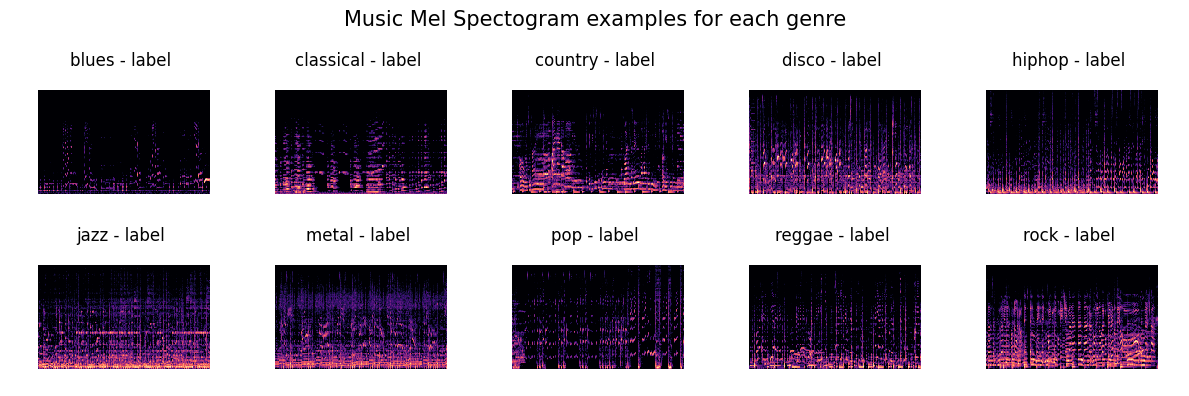

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 4))
axes = axs.ravel()

for i, genre in enumerate(genres):
    music = os.listdir("data/images_original/" + genre)[0]
    path = os.path.join("data/images_original/", genre, music)
    image = plt.imread(path)
    axes[i].imshow(image,interpolation='nearest', aspect='auto')
    axes[i].axis('off')
    axes[i].set_title(genre + " - label")
fig.suptitle("Music Mel Spectogram examples for each genre", fontsize=15)
fig.tight_layout()

One simple method of exploring our data visually is by examining a sample image for each genre. We can see that a Mel spectrogram for each genre shows some variability in both range of frequency and density within timesteps; for instance, the spectrogram for metal music shows a wide range of frequencies with high density, while the spectrogram for reggae shows a much narrower range of frequencies with lower density. This suggests that Mel spectrograms may be able to capture many of the differences between genres that are perceptible to humans, but it needs to be confirmed with more robust analyses, which will be covered in the EDA.

### C. Scaling

We use `ImageDataGenerato` to rescale images and load them into a format suitable for training a CNN. For feature values, we scale using `MinMaxScaler`.

In [ ]:
# Preprocessing for potential CNN training on Mel spectogram images

data_gen = ImageDataGenerator(rescale=1./255.)
image_gen = data_gen.flow_from_directory("data/images_original",
                                            target_size=(432, 288),
                                            batch_size=32,
                                            class_mode="categorical",
                                            shuffle=True,
                                            seed=42
                                        )

Found 999 images belonging to 10 classes.


In [ ]:
# Scaling for the future

X_3_sec = features_3_sec.drop(["label", "filename", "length"], axis=1)
X_30_sec = features_30_sec.drop(["label", "filename", "length"], axis=1)
y_3_sec = features_3_sec["label"]
y_30_sec = features_30_sec["label"]

X_3_sec_norm = MinMaxScaler().fit_transform(X_3_sec)
X_30_sec_norm = MinMaxScaler().fit_transform(X_30_sec)

X_3_sec_norm = pd.DataFrame(X_3_sec_norm, columns=X_3_sec.columns)
X_30_sec_norm = pd.DataFrame(X_30_sec_norm, columns=X_30_sec.columns)

X_3_sec_norm.describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,0.424094,0.658319,0.294161,0.082058,0.348095,0.086759,0.542920,0.094888,0.442597,0.125376,...,0.428798,0.071290,0.381694,0.095385,0.372135,0.078320,0.424239,0.045527,0.497090,0.062669
std,0.140831,0.091239,0.155216,0.109937,0.151591,0.090744,0.169479,0.082134,0.185983,0.114727,...,0.086904,0.050458,0.091780,0.068975,0.089791,0.060957,0.086915,0.036473,0.075205,0.051027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.324718,0.610570,0.187559,0.018842,0.233465,0.025532,0.432627,0.038560,0.308069,0.043014,...,0.373100,0.041399,0.321023,0.053509,0.315700,0.041832,0.369204,0.024059,0.452898,0.032663
50%,0.432199,0.660514,0.272410,0.045723,0.349992,0.055130,0.539552,0.071945,0.449993,0.089272,...,0.429000,0.059151,0.377745,0.077252,0.372028,0.061304,0.420753,0.035407,0.495467,0.048396
75%,0.522026,0.717174,0.397122,0.095993,0.451600,0.117164,0.651040,0.127544,0.558754,0.174186,...,0.484886,0.084893,0.437818,0.113792,0.426703,0.093561,0.475444,0.054609,0.541958,0.074631
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Exploratory Data Analysis

### A. Class-Wise Feature Analysis

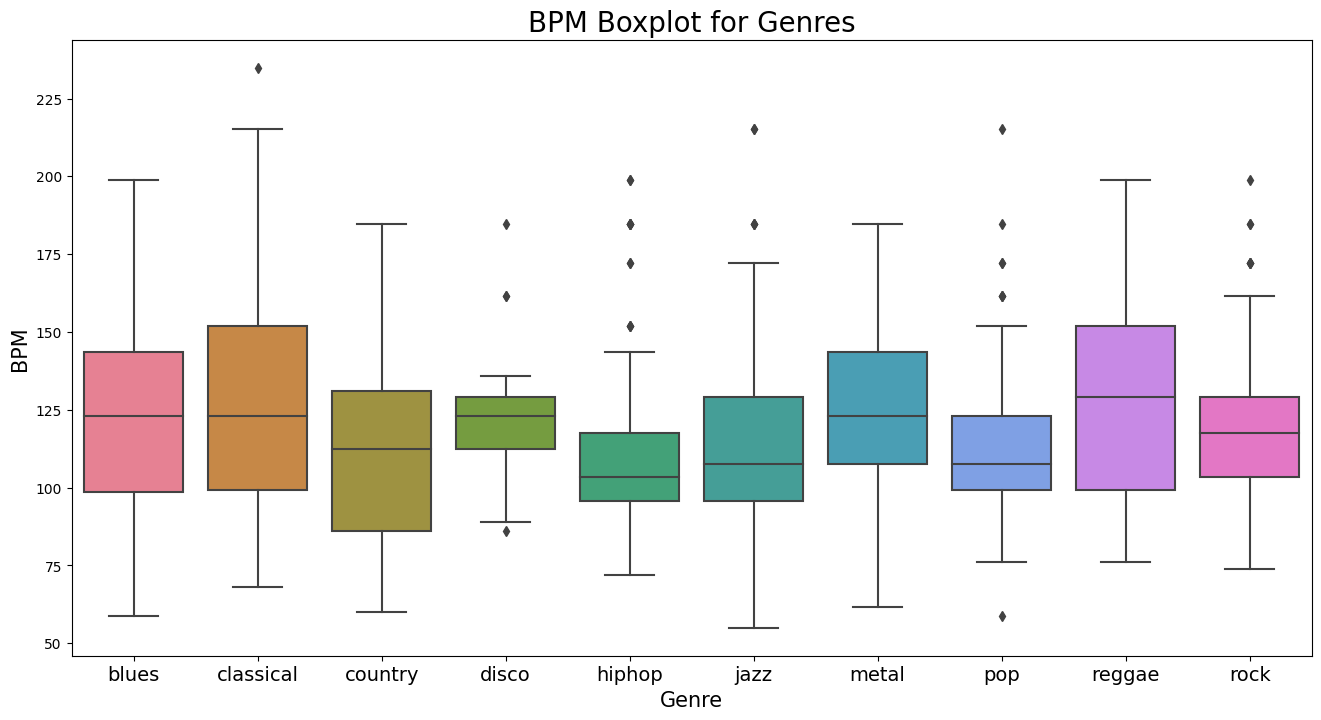

In [ ]:
# Generate boxplot of tempo by genre
# This block of code is from the original Kaggle author
x = features_30_sec[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.show()

Our first impression was that BPM (beats per minute / tempo) may be a defining determinant of genres. In the boxplot, we see that while there are some differences between genres, the differences are not great and meaningful enough. We then move onto looking all the features extracted from the audio files. The two following sets of boxplots show the distribution of the selected features for 30-second sound clips and 3-second sound clips, respectively. For the baseline, we first focus on the mean of the features (e.g., `harmony_mean`) instead of the variance feautres. Also, we ignore the 20 MFCC (Mel Frequency Cepstral Coefficients) features, since they are derived values that are directly tied to the Mel Spectrograms, which we we are testing to see if are appropropriate as neural network inputs. It may be more informative to analyze the relationship between other more raw features and the target variable before diving into the Mel Frequency scale.

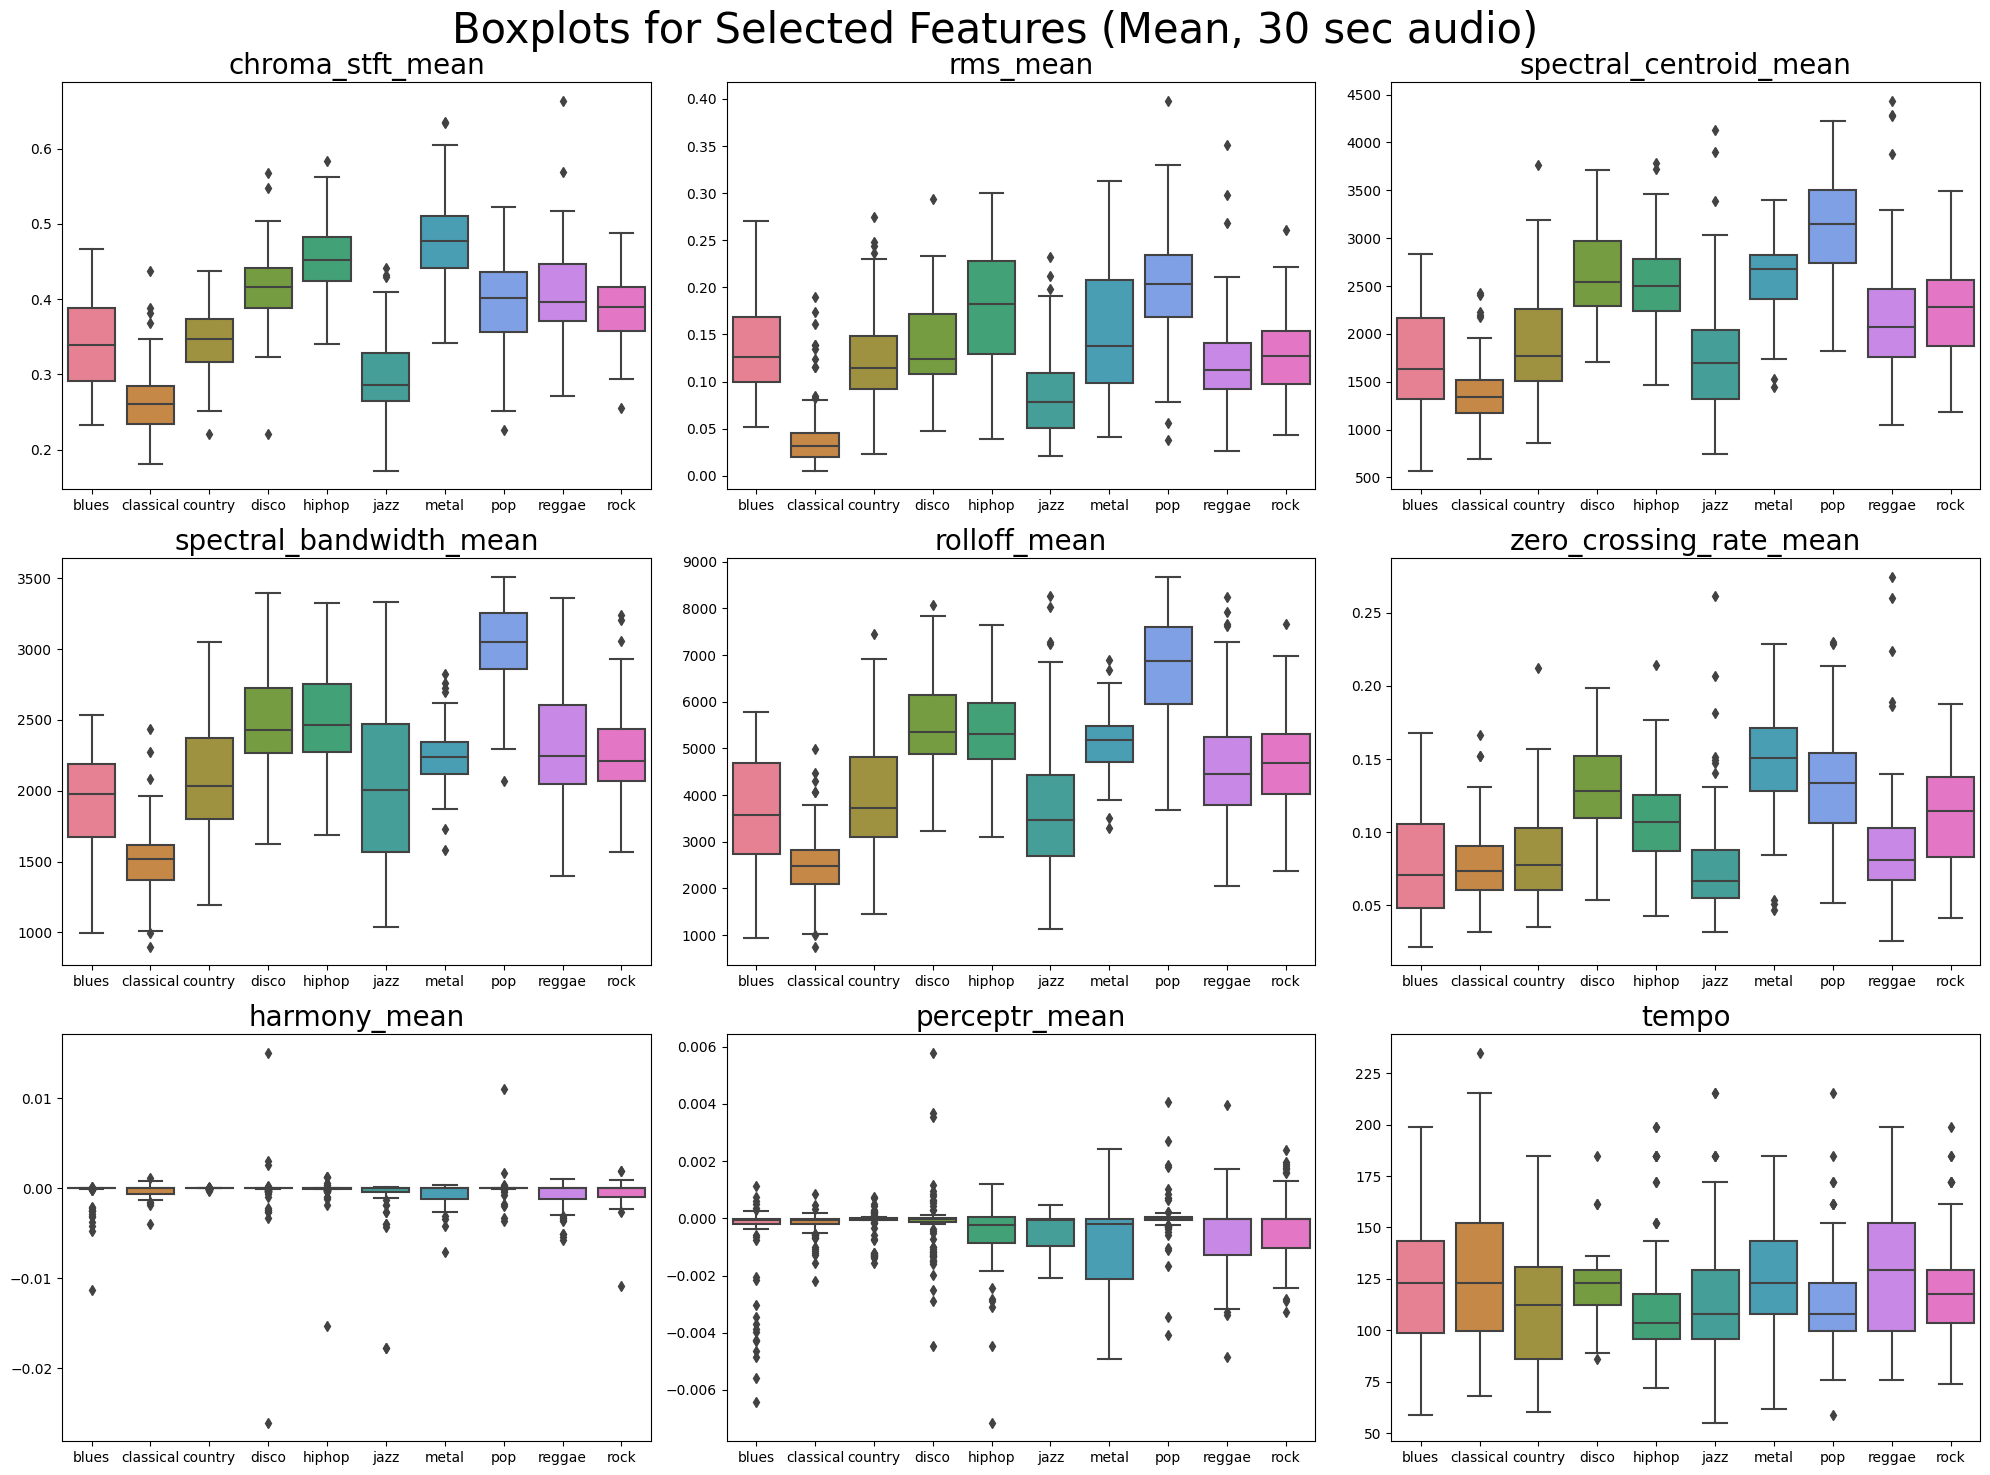

In [ ]:
# Generate boxplots of mean features extracted from 30 sec clips for each genre 
mean_features = ["label", "chroma_stft_mean", "rms_mean", "spectral_centroid_mean", "spectral_bandwidth_mean",
           "rolloff_mean", "zero_crossing_rate_mean", "harmony_mean", "perceptr_mean", "tempo"]
selected_features = features_30_sec[mean_features]
title = "Boxplots for Selected Features (Mean, 30 sec audio)"

# Plot boxplots using helper.py function
plot_boxplots(mean_features, selected_features, title)

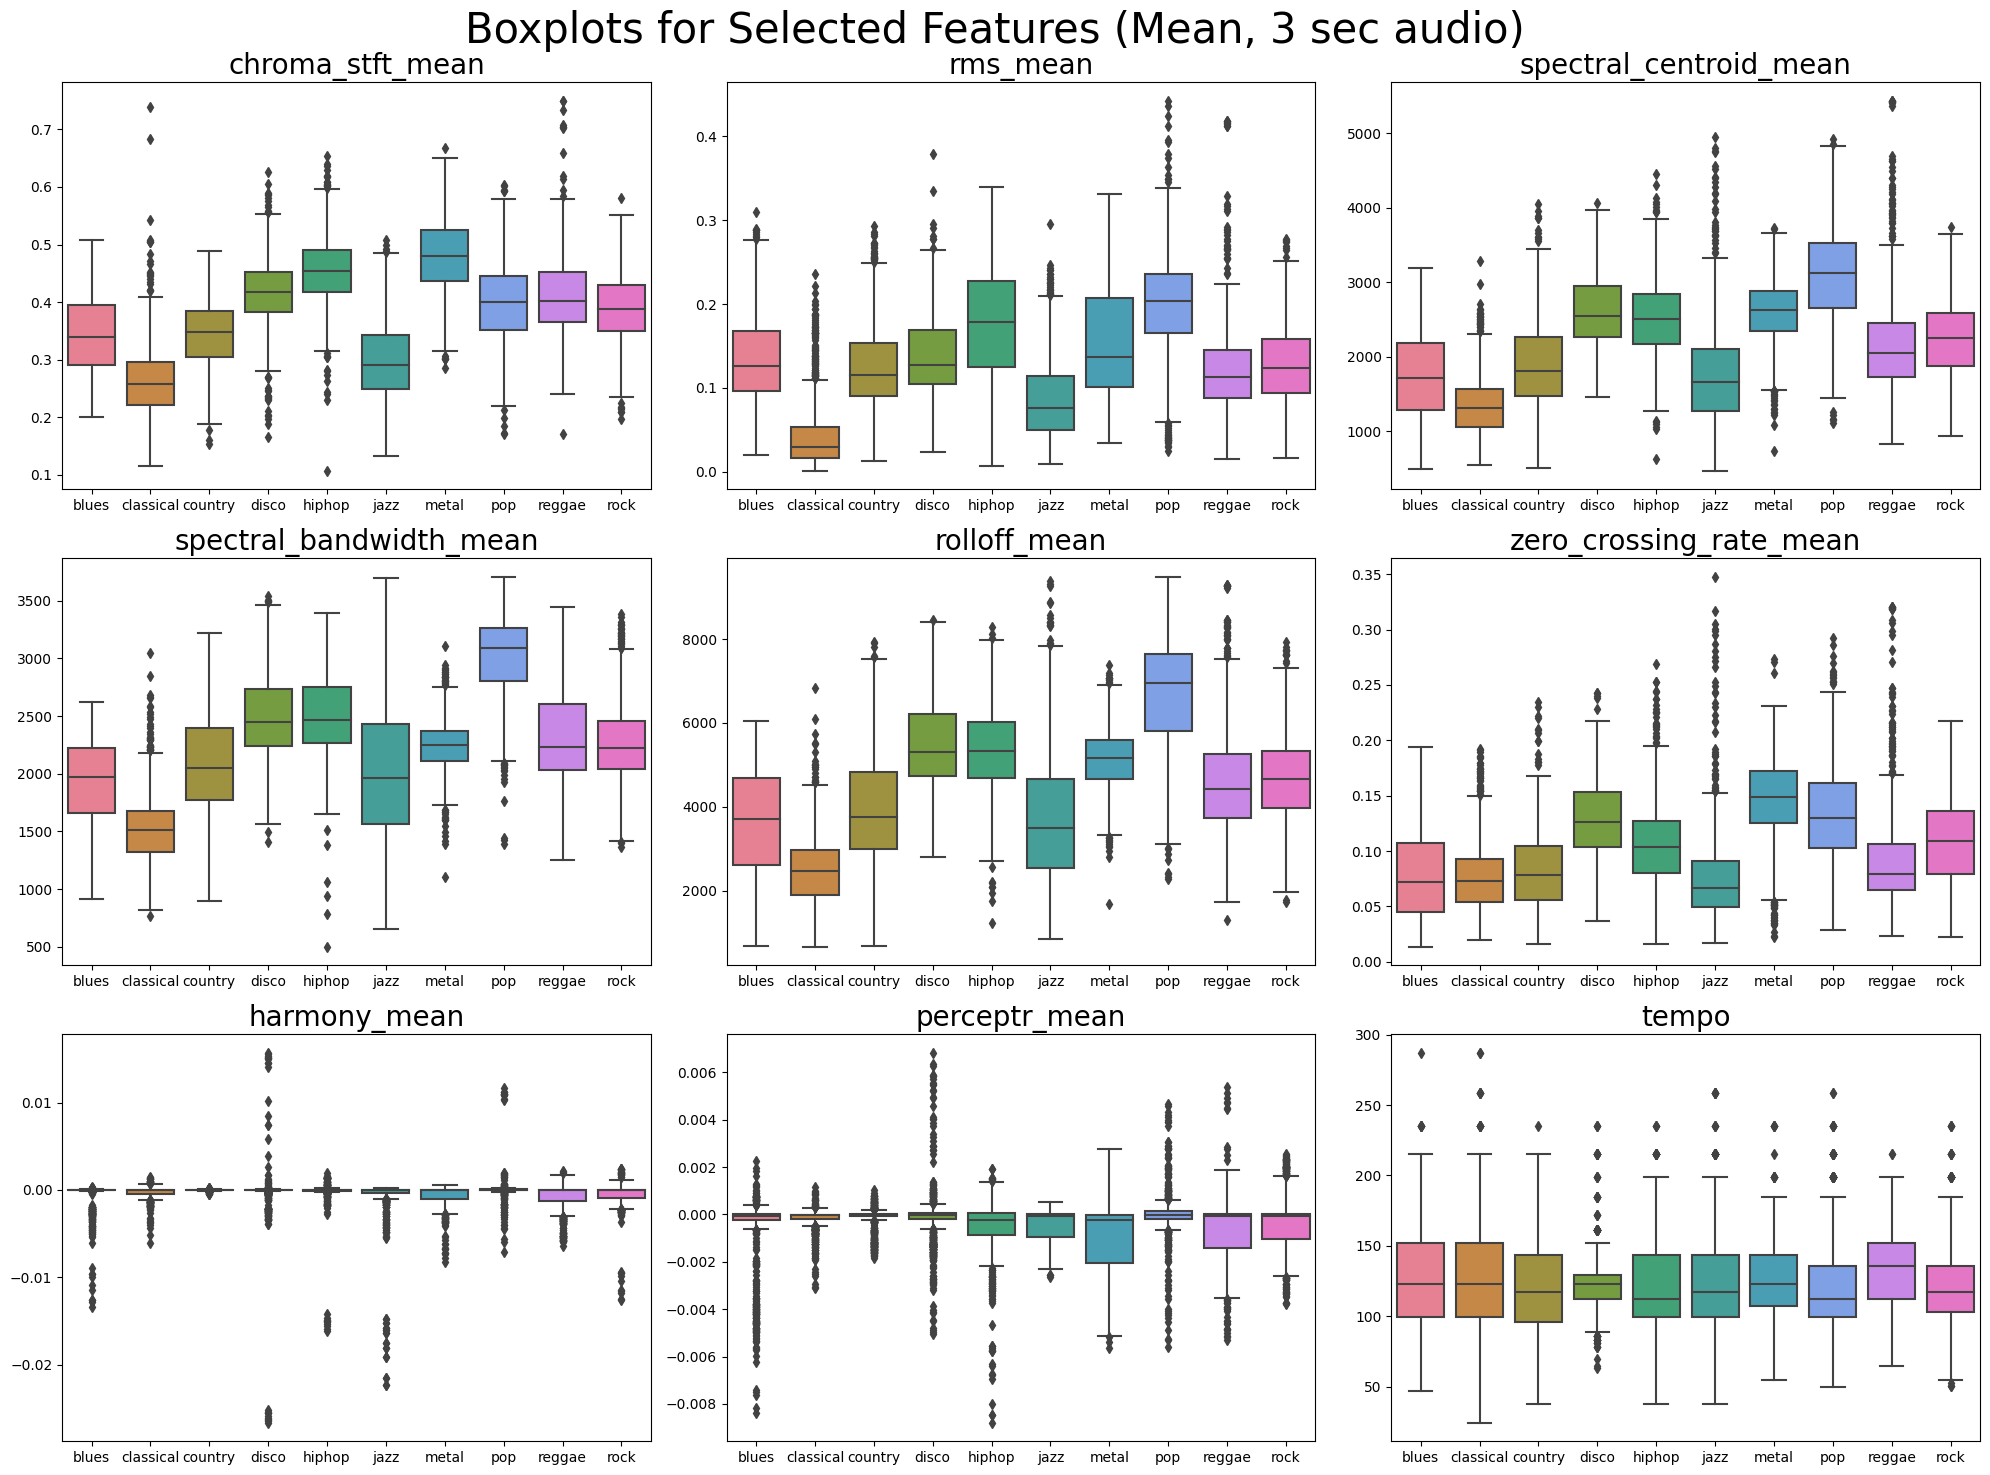

In [ ]:
# Generate boxplots of mean features extracted from 3 sec clips for each genre 
selected_features = features_3_sec[mean_features]
title = "Boxplots for Selected Features (Mean, 3 sec audio)"

# Plot boxplots using helper.py function
plot_boxplots(mean_features, selected_features, title)

The distribution of the extracted sound features above signifies that:
* Feature values are meaningfully different between genres for some extracted features such as **Chroma frequencies, Spectral features (centroid, bandwidth, rolloff)**, while the distribution of other features such as harmony mean and tempo are relatively homogeneous across genres.
* This gives us an initial understanding of which inputs we should be looking for in our model.
* The patterns of sound features are strikingly similar for 30-sec and 3-sec files. Note that the 3-sec clip files are 10 times shorter than the 30-sec version. The fact that feature heterogeneity by genre exists in both 30-sec and 3-sec clips indicates that *even short audio clips contain significant information for genre classification.*

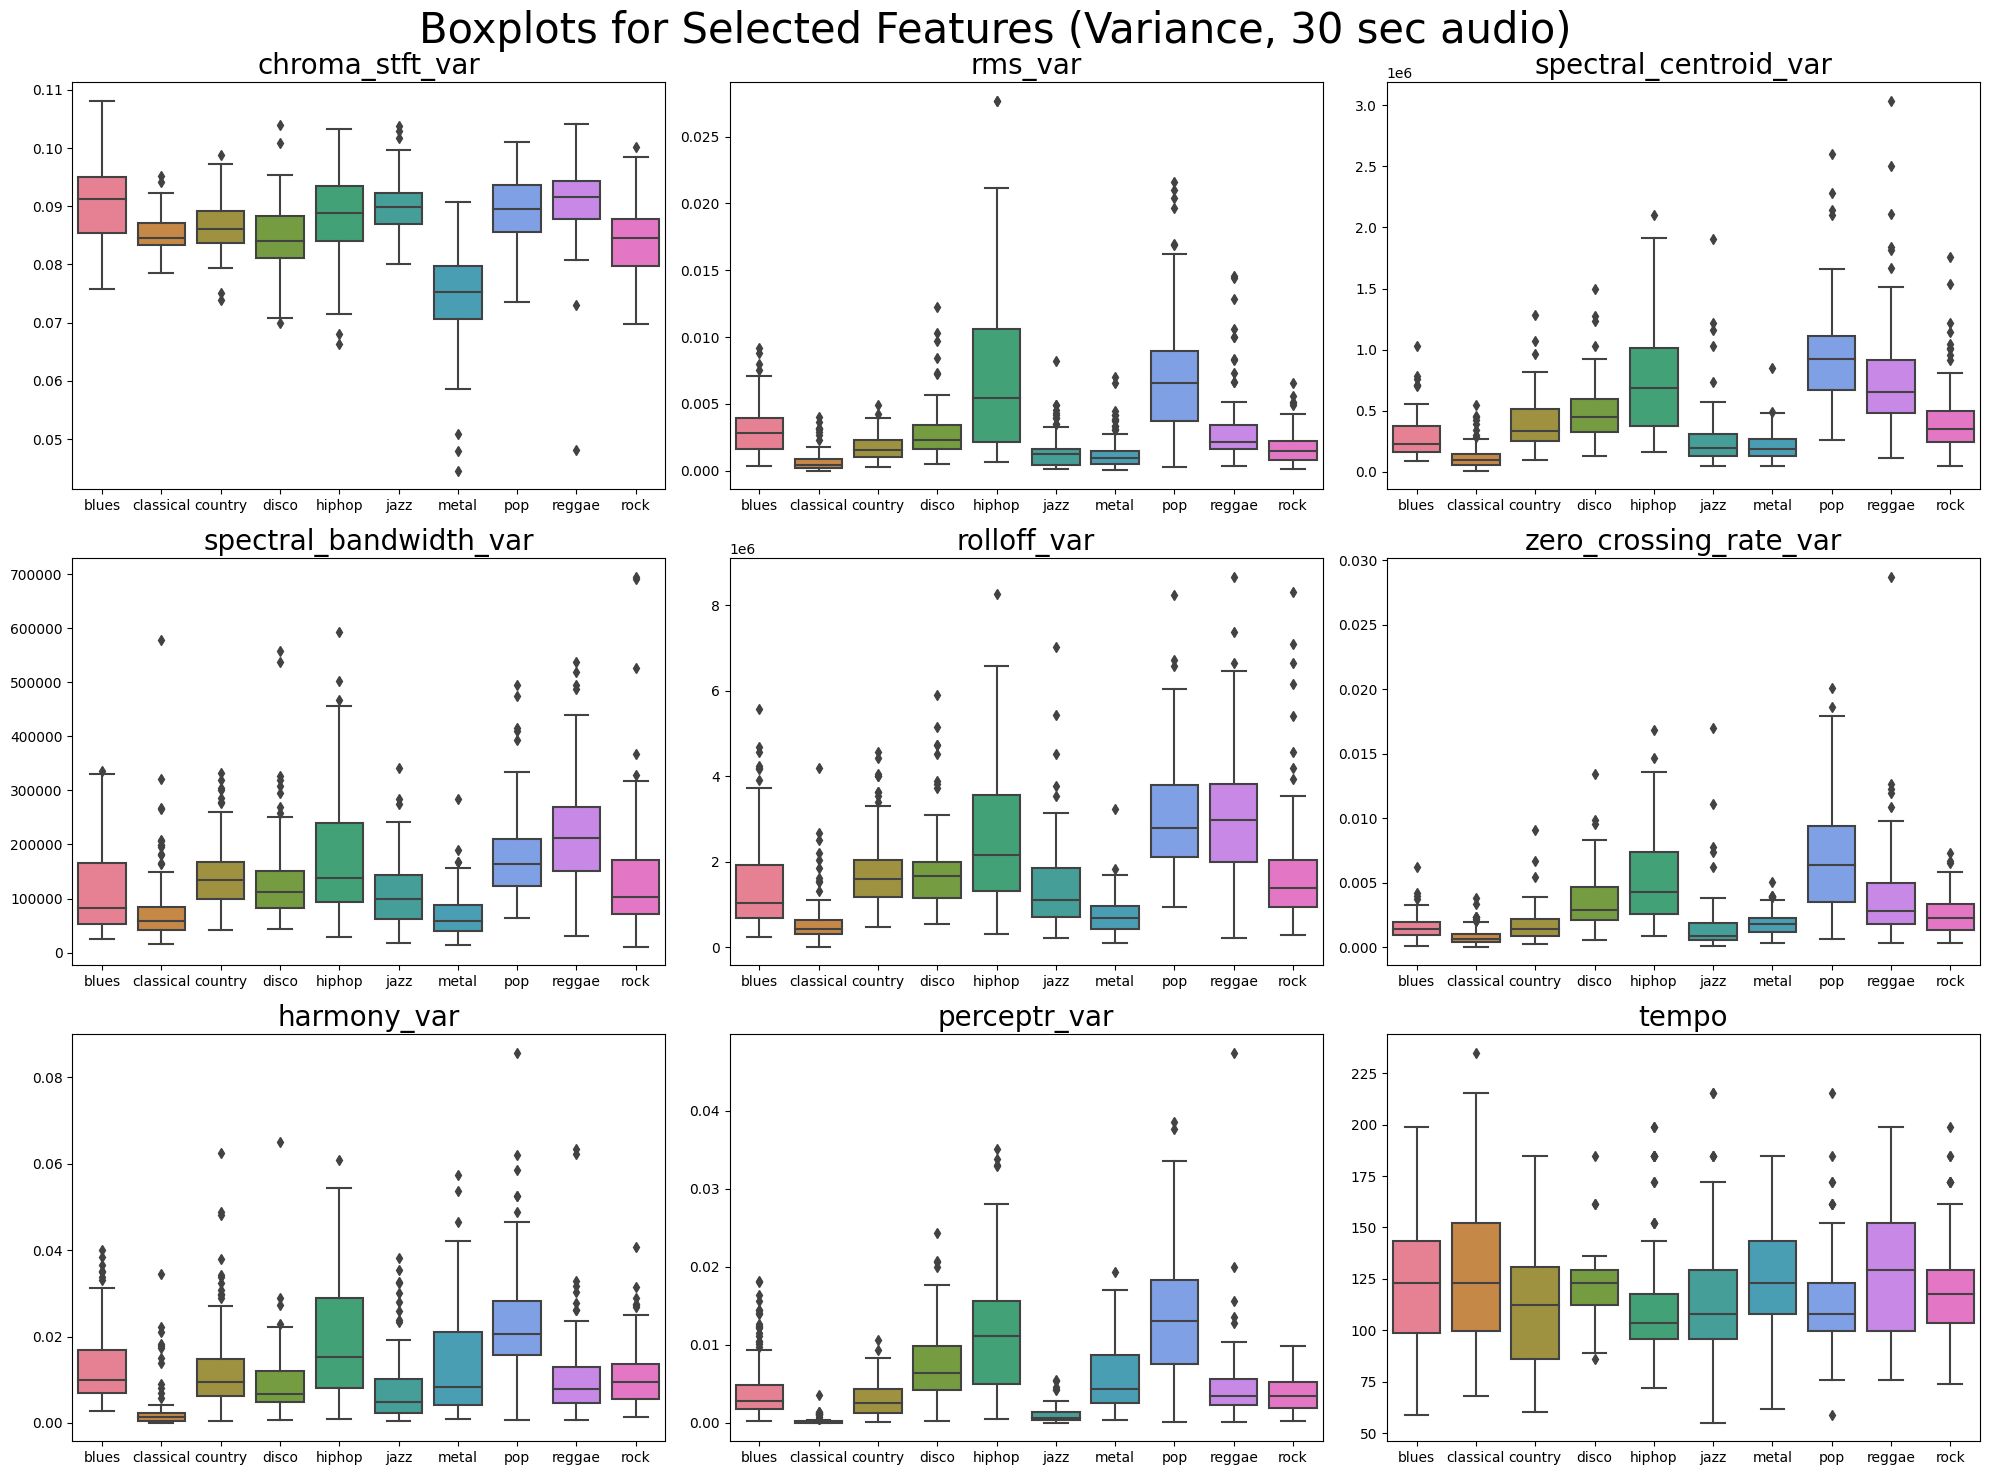

In [ ]:
# Generate boxplots of variance features extracted from 30 sec clips for each genre 
var_features = ["label", "chroma_stft_var", "rms_var", "spectral_centroid_var", "spectral_bandwidth_var",
            "rolloff_var", "zero_crossing_rate_var", "harmony_var", "perceptr_var", "tempo"]

selected_features = features_30_sec[var_features]
title = "Boxplots for Selected Features (Variance, 30 sec audio)"

# Plot boxplots using helper.py function
plot_boxplots(var_features, selected_features, title)

The same class-wise analysis on variance of the features yield the not as distinct but similar results to the mean feautres. Spectral qualities still seem to show distinct differences. Tempo still seems to not be a good indicator of music genre. The fact that variance of audio features is not as distinct as mean of audio features may be due to the fact some features might have inherently more stable or homogeneous values across different genres. For example, harmony and tempo are musical characteristics that may remain relatively stable within a specific music clip or across different clips, regardless of the genre. This also tells us that the mean values of certain features might carry more information about the overall structure and characteristics of a music piece. It's essential to keep in mind that although the variance features might not be as distinct as the mean features, they still provide valuable information for the genre classification task.

### B. MFCC Exploration



Now that we've determined that spectral qualities especially show a lot of distinction between genres and other additional findings, we move onto looking at the aforementioned MFCCs, which are more *derived* data and are directly related to Mel Spectrograms. MFCCs, or Mel Frequency Cepstral Coefficients, are widely used features in the field of music information retrieval and audio processing. MFCCs are a compact representation of the *spectral* shape of a sound and provide a robust description of the timbre, pitch, and overall characteristics of an audio signal. They are particularly useful in speech recognition, speaker identification, and genre classification tasks.

In this dataset, we have 20 MFCC variances and 20 MFCC means. By analyzing the boxplots generated for the means of these coefficients, we can gain insights into the distinctions between different genres based on their MFCC features.

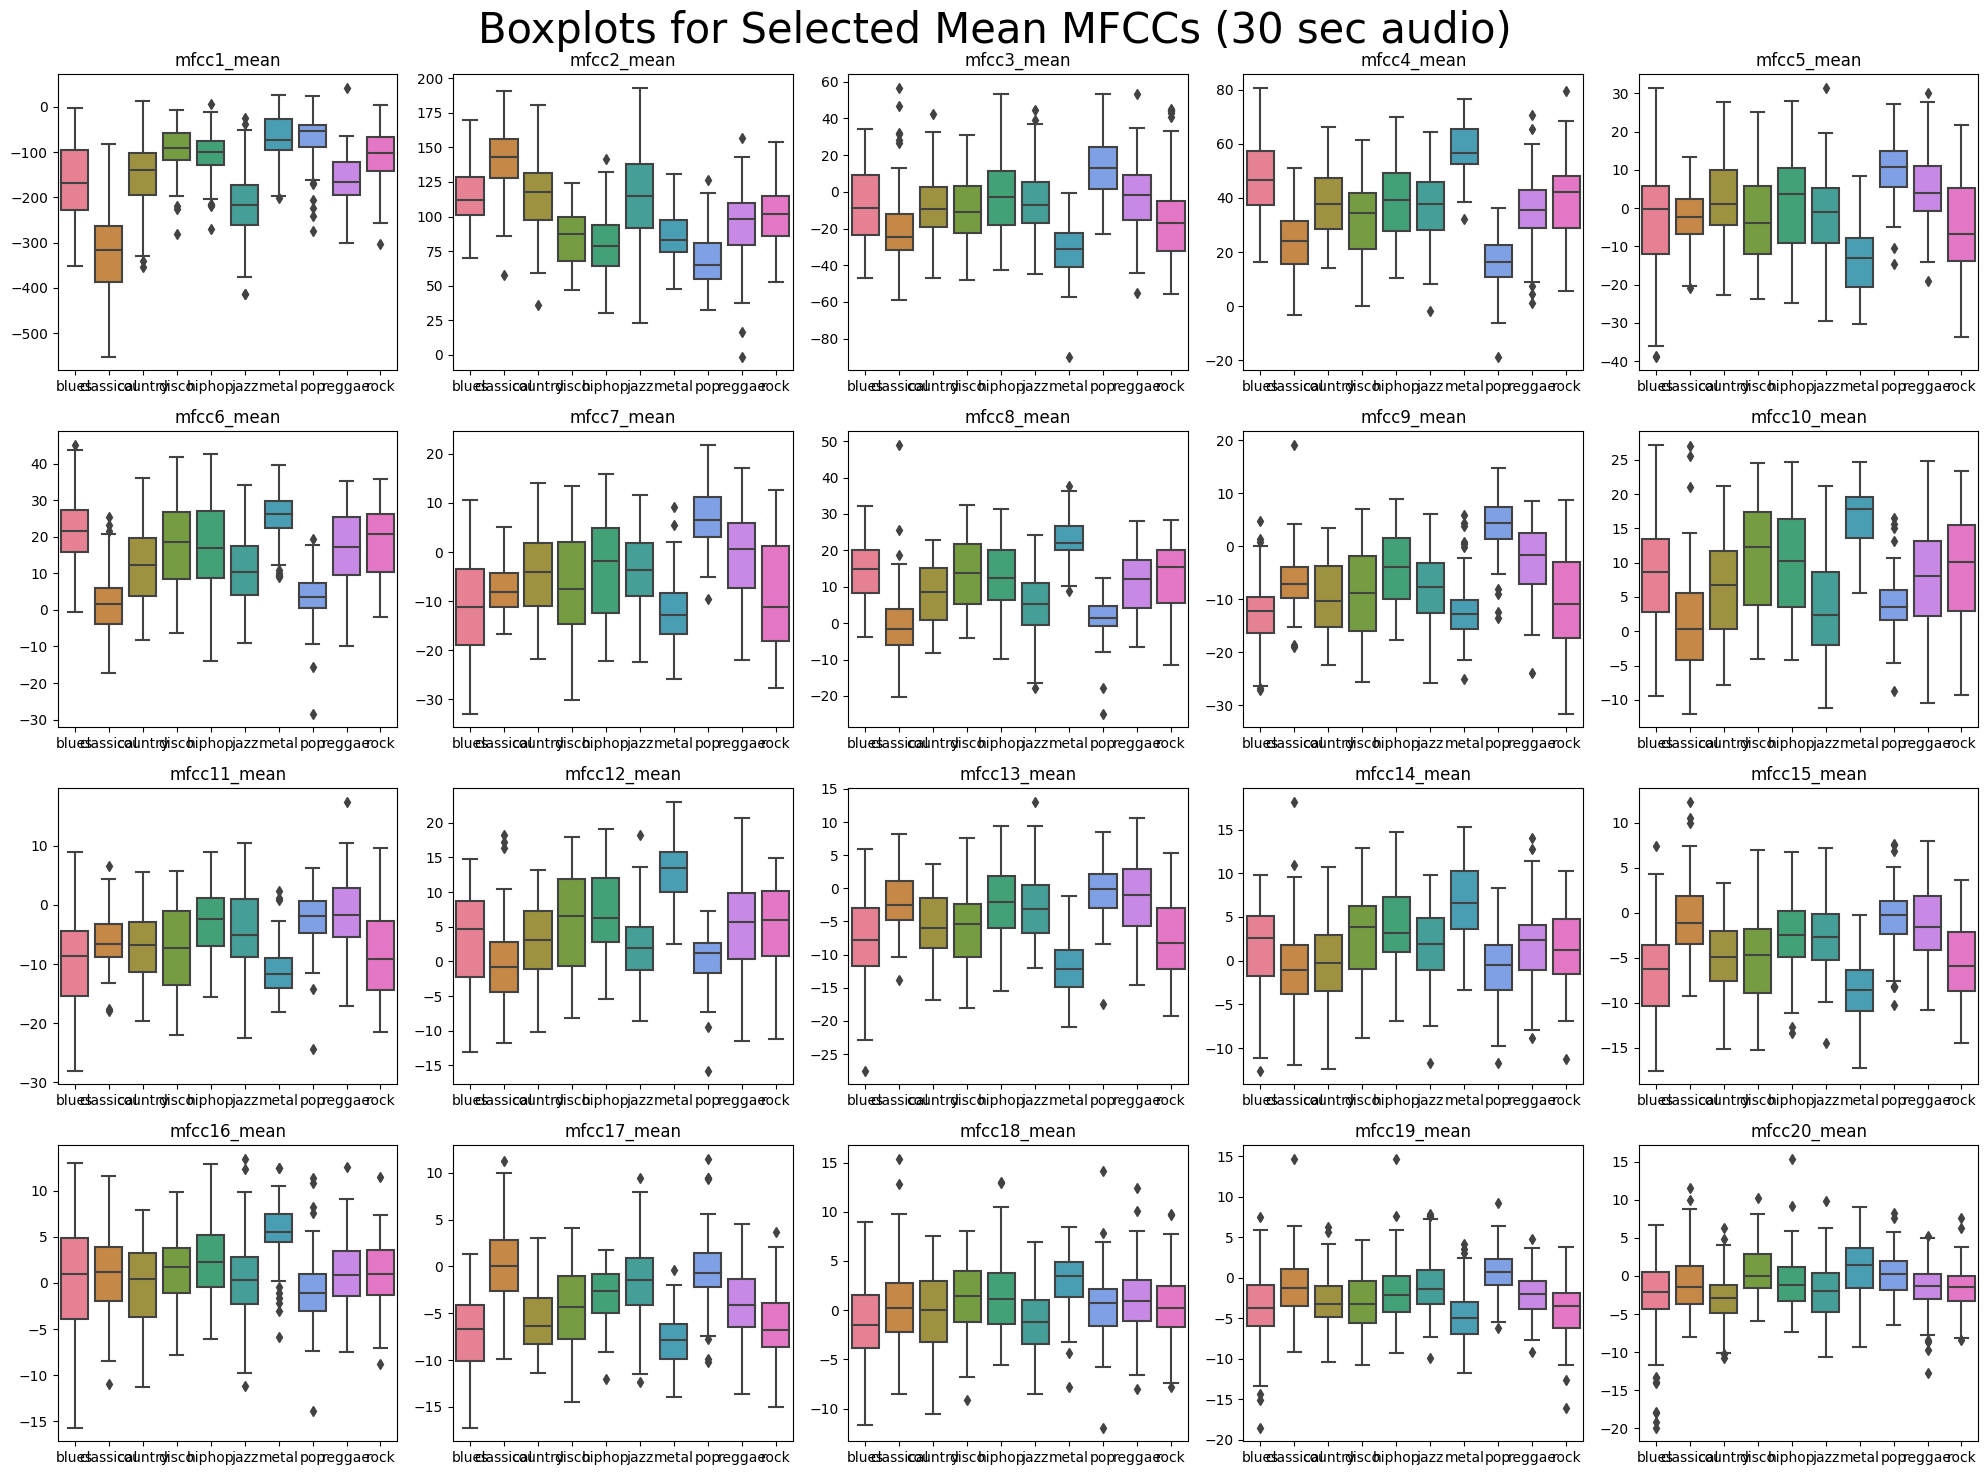

In [ ]:
# Look at mfcc variables
features = ['label'] + [f'mfcc{i}_mean' for i in range(1, 21)]
x = features_30_sec[features]

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20,15))
for i, feature in enumerate(features[1:]):
    row, col = divmod(i,5)
    ax = axs[row,col]
    sns.boxplot(x="label", y=feature, data=x, palette='husl', ax=ax)
    ax.set_title(feature)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='both')

fig.suptitle('Boxplots for Selected Mean MFCCs (30 sec audio)', fontsize=30)
plt.tight_layout()
plt.show()

The boxplots show that there is a generally greater distinction between genres for the first 10 coefficients. This is because the lower-order MFCCs capture the most critical spectral information of an audio signal, such as the overall spectral shape and energy distribution. These coefficients are more likely to capture significant differences in the timbre and pitch characteristics of different genres, making them more informative for genre classification.

In contrast, the higher-order MFCCs represent more subtle and detailed spectral variations in the audio signal. While they may not show as much distinction between genres as the lower-order coefficients, there are instances where specific genres stand out in some of the higher-order MFCCs. For example, the Metal genre shows a meaningful difference in the 12th coefficient mean compared to other genres. This could be attributed to unique spectral characteristics specific to the Metal genre that are captured by the higher-order MFCCs.

In summary, the analysis of MFCC features again confirms the importance of spectral qualities in determining genre. We begin to feel confident about using Mel Spectrograms, which are also on the same Mel scale as MFCCs, as image inputs for the CNN model.

### C. Correlation Heatmaps

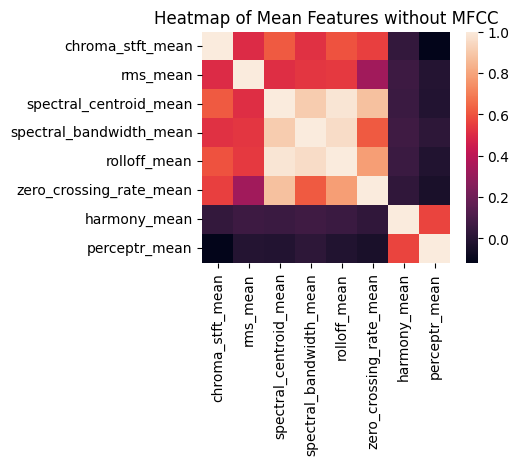

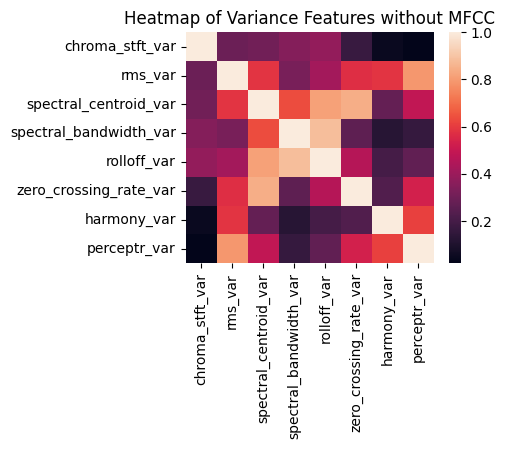

In [ ]:
# Removing MFCC features
X_30_sec_norm_no_mfcc = X_30_sec_norm.drop(X_30_sec_norm.filter(regex='mfcc').columns, axis=1)

# Correlation analysis
plot_heatmap(X_30_sec_norm_no_mfcc.filter(regex='mean'), "Heatmap of Mean Features without MFCC")
plot_heatmap(X_30_sec_norm_no_mfcc.filter(regex='var'), "Heatmap of Variance Features without MFCC")

The heatmap generated on non-MFCC features show that for mean values especially, there are high correlation between Chroma qualities, RMS Energy, spectral features, and zero crossing rates. These features are related to the spectral content and energy distribution of the audio signals, and since these features are all derived from the frequency domain and depend on the distribution of energy in the signal, it is expected that they would be correlated. Mean harmonics and perceptuals are not correlated with other features. Harmony features capture the harmonic content of the signal, which relates to the underlying musical structure and the presence of tonal relationships. Perceptual features are based on human auditory perception and aim to capture the perceived loudness, sharpness, and other aspects of the sound that are not directly related to the frequency domain. They are not connected to other musical features since they measure different aspects of the audio signal.

### D. Feature Importances

For a more refined EDA, we analyze feature importances in order to determine the best image representation to use as input for our CNN. Our aim is to confirm whether Mel Spectrograms are indeed the best option to use for our project, given the extracted features from audio files.

To analyze feature importances in our refined EDA, we use a RandomForestClassifier to determine the significance of each normalized feature. The top features, according to their importance are as follows:

In [ ]:
# Feature importance ranking
importances, features, rf, X_train, X_test, y_train, y_test = get_feature_importances(X_30_sec_norm, y_30_sec)

# Print the top 10 ranked features by importance
indices = np.argsort(importances)[::-1]
for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

1. chroma_stft_mean (0.049073)
2. perceptr_var (0.045378)
3. rms_mean (0.035685)
4. mfcc4_mean (0.029936)
5. chroma_stft_var (0.029460)
6. rms_var (0.028130)
7. spectral_centroid_var (0.028045)
8. rolloff_mean (0.026383)
9. spectral_bandwidth_mean (0.026151)
10. mfcc5_var (0.025630)


While this echoes the findings from the initial EDA, it is worth noting the singling out of the fourth and the fifth MFCC coefficients by the RandomForestClassifier. MFCC 4 and MFCC 5 cover a critical spectral range (600-1000 Hz), which in music captures much of the harmonics of musical instruments commonly used across various genres. Moreover, the human voice, especially the vocal formants (resonant frequencies), falls within the same range. Vocal styles and instruments can vary significantly across genres, and these MFCCs can capture these differences, helping to identify the genre.

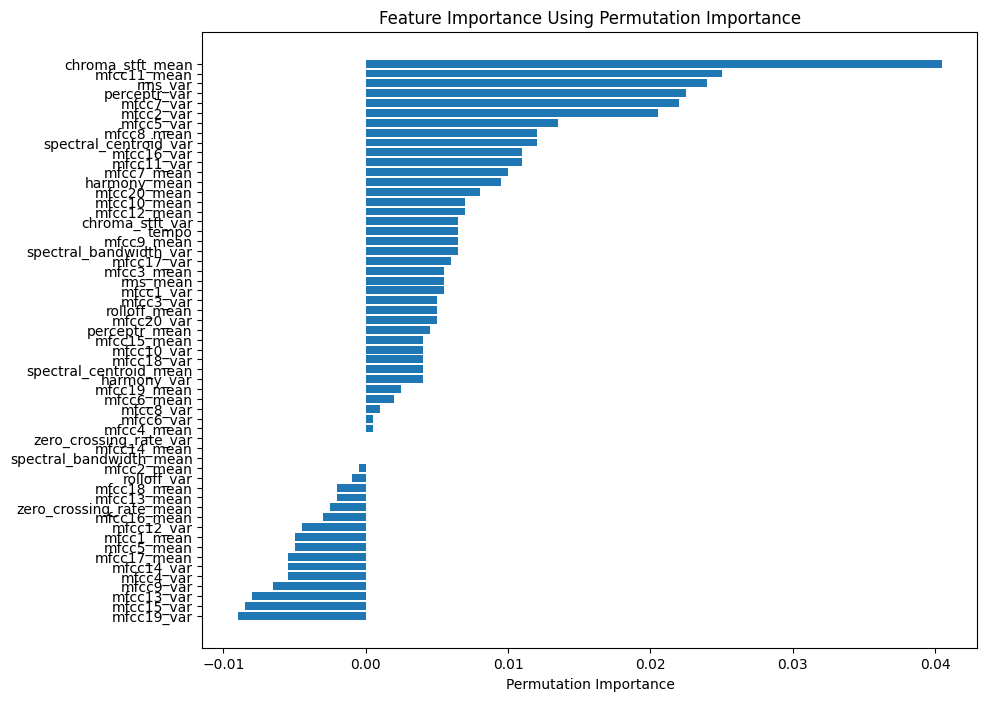

In [ ]:
# Permutation importance analysis
result = plot_permutation_importance(rf, X_test, y_test)

We performed further analysis using permutation importance. By shuffling the values of a single feature and measuring the change in model performance, we see the relative importance of the features. The result from the permutation importance analysis was largely consistent with the RandomForestClassifier, but showing additionally outsized importance for `chroma_stft_mean`.

In [ ]:
# Removing features with negative permutation importance
positive_permutation_importance_indices = np.where(result.importances_mean > 0)[0]
positive_features = X_test.columns[positive_permutation_importance_indices]
X_30_sec_positive_features = X_30_sec_norm[positive_features]

1. perceptr_var (0.063134)
2. chroma_stft_mean (0.058285)
3. rms_mean (0.039727)
4. rms_var (0.039575)
5. spectral_centroid_var (0.037998)
6. mfcc4_mean (0.037930)
7. chroma_stft_var (0.037422)
8. rolloff_mean (0.037234)
9. spectral_centroid_mean (0.034062)
10. mfcc5_var (0.033919)


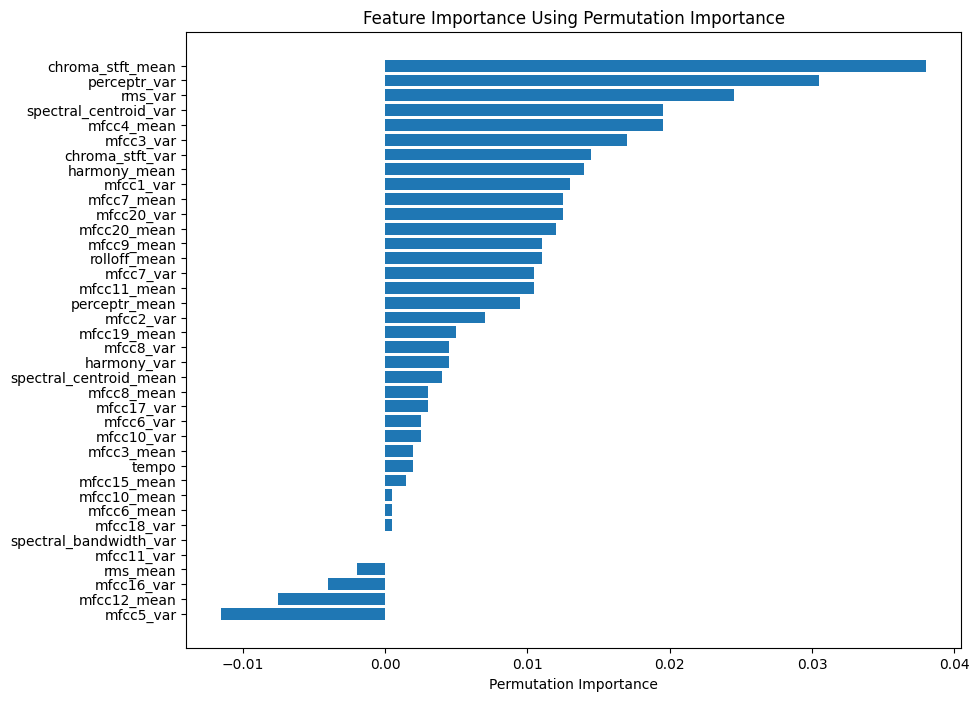

In [ ]:
# Training a random forest classifier with reduced features
importances, features, rf2, X_train, X_test, y_train, y_test = get_feature_importances(X_30_sec_positive_features, y_30_sec)

# Print the ranked features by importance
indices = np.argsort(importances)[::-1]
for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Permutation importance analysis for reduced features
result = plot_permutation_importance(rf2, X_test, y_test)

In [ ]:
# Compute the correlation matrix
corr_matrix = X_30_sec_norm.corr()

# Set a threshold for highly correlated features
correlation_threshold = 0.7

# Identify highly correlated feature pairs
highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            colname = corr_matrix.columns[i]
            highly_correlated_features.add(colname)

# Remove highly correlated features
X_30_sec_reduced = X_30_sec_norm.drop(columns=highly_correlated_features)

In [ ]:
print(highly_correlated_features)
print(X_30_sec_reduced.columns)

{'mfcc2_mean', 'mfcc7_mean', 'mfcc12_mean', 'zero_crossing_rate_mean', 'mfcc15_mean', 'spectral_bandwidth_mean', 'mfcc14_mean', 'mfcc11_mean', 'zero_crossing_rate_var', 'rolloff_mean', 'mfcc12_var', 'mfcc9_mean', 'mfcc6_var', 'mfcc10_var', 'mfcc16_var', 'rolloff_var', 'mfcc15_var', 'mfcc14_var', 'mfcc20_var', 'mfcc10_mean', 'mfcc8_mean', 'harmony_var', 'mfcc19_var', 'perceptr_var', 'mfcc11_var', 'mfcc13_var', 'mfcc17_var', 'mfcc1_mean', 'mfcc18_var', 'mfcc13_mean'}
Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_var', 'harmony_mean', 'perceptr_mean', 'tempo',
       'mfcc1_var', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean',
       'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc7_var',
       'mfcc8_var', 'mfcc9_var', 'mfcc16_mean', 'mfcc17_mean', 'mfcc18_mean',
       'mfcc19_mean', 'mfcc20_mean'],
      dtype='object')


1. chroma_stft_mean (0.083313)
2. rms_mean (0.063716)
3. mfcc4_mean (0.056679)
4. spectral_centroid_mean (0.055815)
5. spectral_centroid_var (0.055380)
6. rms_var (0.054845)
7. chroma_stft_var (0.053463)
8. mfcc5_var (0.041074)
9. mfcc17_mean (0.039312)
10. mfcc6_mean (0.037485)


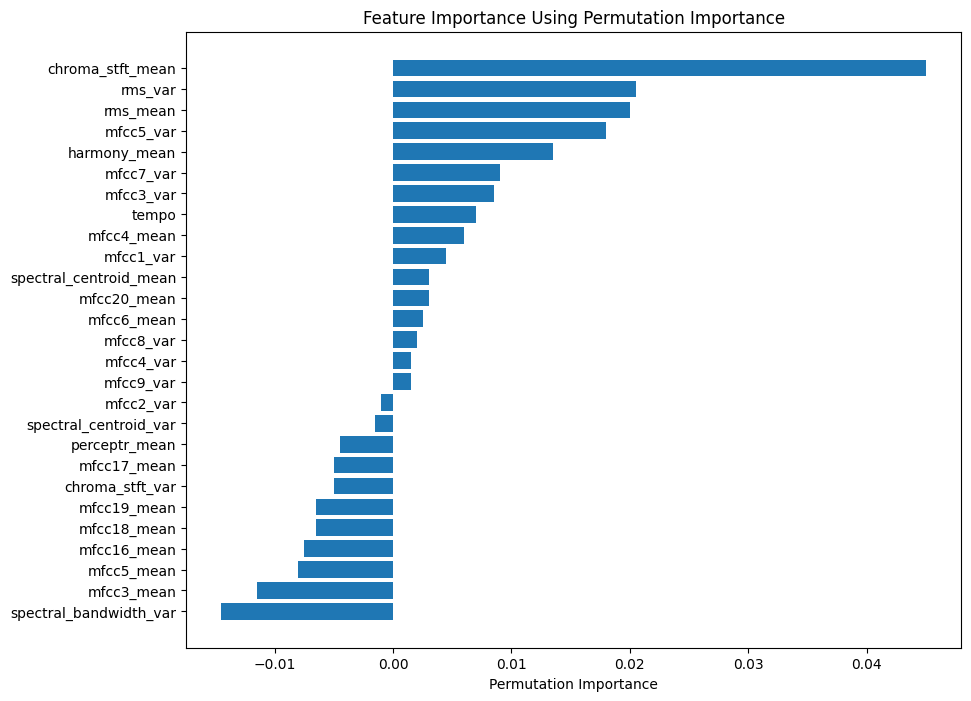

In [ ]:
# Training a random forest classifier with reduced features
importances, features, rf3, X_train, X_test, y_train, y_test = get_feature_importances(X_30_sec_reduced, y_30_sec)

# Print the ranked features by importance
indices = np.argsort(importances)[::-1]
for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Permutation importance analysis for reduced features
result = plot_permutation_importance(rf3, X_test, y_test)

We attempt running the same permutation importance analysis by first removing all features with negative importances in the first instance of the analysis. We also run another analysis having removed features that are highly correlated with each other (correlation threshold of 0.7). All analyses confirm the same conclusion of the importance of Chroma features.

So, are Mel Spectrograms the best choice for image input for the genre classification problem?

Chroma features (`chroma_stft`), the most important feature according to the random forest models, represent the harmonic content of the audio signal and can be indirectly captured in Mel spectrograms; both chroma features and Mel spectrograms are derived from the spectral content of the signal. Perceptual features (`perceptr_var`) are related to human auditory perception and may not be directly captured in Mel spectrograms, but since Mel spectrograms are designed to mimic the human auditory system's response to different frequencies, they might indirectly capture some aspects of perceptual features. RMS (`rms_mean`) is the root mean square of the audio signal and is a measure of the signal's energy. The energy of the signal is indirectly captured in the form of amplitudes across different frequency bands, therefore being highly related to Mel spectrograms.

In summary, while Mel spectrograms may not directly capture all of the top features identified by the feature importance analysis, they do contain related information and provide a comprehensive representation of the audio signal. This makes Mel spectrograms a suitable choice for our model, confirming our findings from the literature review.


### E. Principal Components Analysis

Cumulative explained variance ratio:
[0.24644968 0.4667316  0.56476919 0.62988441 0.68335235 0.72170848
 0.74897858 0.77113958 0.79246365 0.80897011 0.8223882  0.83557751
 0.84700181 0.85696377 0.86626528 0.87496265 0.8831061  0.89046546
 0.89747763 0.90404329]


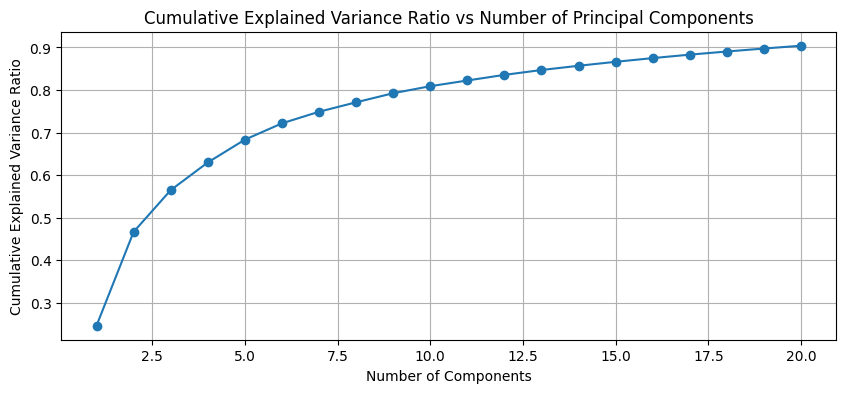

In [ ]:
# Perform PCA
pca_csv = PCA(n_components=20).fit(X_30_sec_norm)

# Sort explained variance ratio in descending order
explained_variance_ratio = pca_csv.explained_variance_ratio_
explained_variance_ratio_sorted = np.sort(explained_variance_ratio)[::-1]

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio_sorted)

# Print the cumulative explained variance ratio
print("Cumulative explained variance ratio:")
print(cumulative_explained_variance_ratio)

# Plot the cumulative explained variance ratio
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust the figsize parameter for a smaller plot

plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Principal Components')
plt.grid()
plt.show()


The first principal component (PC1) explains 24.64% of the total variance in the data. The first two principal components (PC1 and PC2) together explain 46.67% of the total variance. However, after considering 20 principal components, only about 90.4% of the total variance is explained.

This suggests that the given feature set is not sufficient to capture all the information present in the music files, and a significant portion of the variance remains unexplained. This again supports the idea that utilizing Mel Spectrograms and CNNs for genre classification is appropriate, as they can better capture the intricate relationships and patterns of numerous extracted features at once.

## 4. Image Data Labeling and Augmentation

### A. Labeling Mel Spectrogram Image Data

In [ ]:
# Update X with image input data and y with corresponding target genre labels (0-9)
X, y = [], []
image_dict = {}
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for i, genre in enumerate(genres):
    # Read images from each genre folder
    genre_folder = os.path.join("data/images_original/", genre)
    images_by_genre = []
    for image_file in os.listdir(genre_folder):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
            image_path = os.path.join(genre_folder, image_file)
            image = plt.imread(image_path)
            images_by_genre.append(image)

    X += images_by_genre
    y += [i for _ in images_by_genre]
    image_dict[genre] = images_by_genre

print('X shape:', np.array(X).shape)
print('y shape:', np.array(y).shape)

X shape: (999, 288, 432, 4)
y shape: (999,)


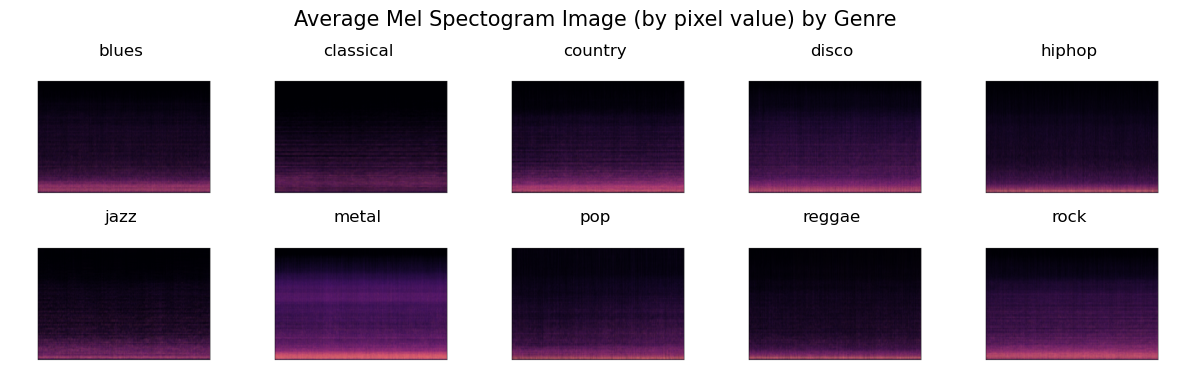

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 4))
axes = axs.ravel()

# Plot mean image for each genre
for i, genre in enumerate(genres):
    average_image = np.mean(image_dict[genre],axis=0)
    axes[i].imshow(average_image)
    axes[i].axis('off')
    axes[i].set_title(genre)
fig.suptitle("Average Mel Spectogram Image (by pixel value) by Genre", fontsize=15)
fig.tight_layout()

### B. Creating Dataset Split and Augmentation

The GTZAN dataset includes 100 audio files for each of 10 genres; given the relatively small amount of data, proper augmentation techniques will ensure greater model strength. Since our baseline approach uses Mel spectrograms as inputs for the CNN, our data augmentation methods focus on manipulating the spectrograms themselves. One viable augmentation technique we use is cropping or slicing the spectrograms into smaller sections. This helps the model learn to recognize different aspects of the spectrograms and improves its robustness to variations in unseen data.

In [ ]:
# Create train-test split, stratifying on genre to ensure balanced classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=109)

# Print class distributions in train and test sets
print("Train set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("Test set:")
print(pd.Series(y_test).value_counts(normalize=True))

Train set:
3    0.100125
7    0.100125
9    0.100125
0    0.100125
6    0.100125
1    0.100125
2    0.100125
4    0.100125
8    0.100125
5    0.098874
Name: proportion, dtype: float64
Test set:
7    0.1
3    0.1
1    0.1
0    0.1
8    0.1
6    0.1
4    0.1
2    0.1
9    0.1
5    0.1
Name: proportion, dtype: float64


We define a generator function to create random slices from our spectrogram samples, using slice width and number of slices as parameters. We aim to explore the tradeoff between using larger slices, which will capture more of the long-term structure of each spectrogram, and using smaller slices, which will add more variance to our training data. Similarly, using more slices will increase the size of our dataset, at the cost of potentially leading to overfitting due to the presence of many similar samples. By comparing the performance of various augmentation plans on a baseline model, we aim to optimize for the best combination of hyperparameters that will help our model learn to generalize on unseen data. 

In [ ]:
# Define generator for original dataset
def normal_generator(X, y):
    for i in range(len(X)):
        yield X[i, :, :, :3], y[i]

# Recreate original dataset using generators
train_dataset_original = tf.data.Dataset.from_generator(
    lambda: normal_generator(np.array(X_train), np.array(y_train)),
    output_types=(tf.float32, tf.int64),
    output_shapes=((288, 432, 3), ()))

test_dataset_original = tf.data.Dataset.from_generator(
    lambda: normal_generator(np.array(X_test), np.array(y_test)),
    output_types=(tf.float32, tf.int64),
    output_shapes=((288, 432, 3), ()))

2023-05-09 02:34:34.857024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-09 02:34:40.152564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-09 02:34:40.152895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# Define random slice generator 
def random_slice_generator(X, y, p=1/3, num_slices=4):
    num_samples, height, width, channels = X.shape
    slice_width = math.floor(width * p)
    
    for i in range(num_samples):
        # For each sample, create several slices with random starting points
        for j in range(num_slices):
            start = random.randint(0, width-slice_width)
            end = start + slice_width
                
            yield X[i, :, int(start):int(end), :3], y[i]
            
# Helper function to create augmented datasets
def generate_augmented_datasets(p, num_slices):
    train_slice_gen = random_slice_generator(np.array(X_train), np.array(y_train), p=p, num_slices=num_slices)
    test_slice_gen = random_slice_generator(np.array(X_test), np.array(y_test), p=p, num_slices=num_slices)

    # use generators to create augmented datasets
    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_slice_gen,
        output_types=(tf.float32, tf.int64),
        output_shapes=((288, int(432*p), 3), ()))

    test_dataset = tf.data.Dataset.from_generator(
        lambda: test_slice_gen,
        output_types=(tf.float32, tf.int64),
        output_shapes=((288, int(432*p), 3), ()))
    
    return train_dataset, test_dataset

In [ ]:
# Create augmented datasets using generators
train_dataset, test_dataset = generate_augmented_datasets(p=1/3, num_slices=4)

We have considered other augmentation options such as pitch-shifting and time-scaling, but these would require manipulation of the audio data before generating the spectrograms. For the baseline model, we focus on the more direct approach of slicing the spectrograms, as it maintains the integrity of the audio features while still providing a beneficial augmentation technique. Further areas for exploration include SpecAugment, a method that involves randomly masking bands of frequency or time to improve generalizability.

### C. Dataset Evaluation

We train a baseline ConvNeXtTiny model for quick evaluation of our variously augmented datasets, with the aim of using an improved version of the model later on to evaluate our final choice of dataset.

In [ ]:
# Get input shape
import random
image_shape = None
for element in train_dataset.take(1).as_numpy_iterator():
    image_shape = element[0].shape
    print(f'The input shape of each image is: {image_shape}')

# Import ConvNeXtTiny weights from Keras for transfer learning
convnext_tiny = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=image_shape)

2023-05-09 02:35:20.939306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


The input shape of each image is: (288, 144, 3)
111650432/111650432 [==============================] - 0s 0us/step


In [ ]:
# Freeze weights of pre-trained layers
for layer in convnext_tiny.layers:
    layer.trainable = False

# Add new classification layer on top of pre-trained model
x = Flatten()(convnext_tiny.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

# Create the new model with the pre-trained layers and new classification layer
convnext_model = Model(inputs=convnext_tiny.input, outputs=output)

# Compile the model
convnext_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
convnext_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 288, 144, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 72, 36, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                                                               tion[0][0]']                 

In [ ]:
# Fit and evaluate model on training data
NUM_EPOCHS = 5
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Use caching, batching, and prefetching to speed up model fitting
train_ds_batched = train_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds_batched = test_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

history = convnext_model.fit(train_ds_batched, epochs=NUM_EPOCHS, validation_data=test_ds_batched)

Epoch 1/5


2023-05-09 02:35:27.011336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-09 02:36:26.727929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-09 02:37:05.034973: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-09 02:37:07.381420: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ff0f81f9990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-09 02:37:07.381470: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-09 02:37:08.643442: I tensorflow/tsl/platform/default/subprocess.cc:304] S

    100/Unknown - 131s 206ms/step - loss: 2.7685 - accuracy: 0.1133

2023-05-09 02:37:38.736501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 139s 287ms/step - loss: 2.7685 - accuracy: 0.1133 - val_loss: 2.2434 - val_accuracy: 0.1762
Epoch 2/5
100/100 [==============================] - 23s 227ms/step - loss: 2.2560 - accuracy: 0.1152 - val_loss: 2.1600 - val_accuracy: 0.1538
Epoch 3/5
100/100 [==============================] - 23s 228ms/step - loss: 2.2211 - accuracy: 0.1092 - val_loss: 2.2399 - val_accuracy: 0.1400
Epoch 4/5
100/100 [==============================] - 23s 230ms/step - loss: 2.2023 - accuracy: 0.1293 - val_loss: 2.1225 - val_accuracy: 0.1925
Epoch 5/5
100/100 [==============================] - 23s 231ms/step - loss: 2.1737 - accuracy: 0.1424 - val_loss: 2.1038 - val_accuracy: 0.2075


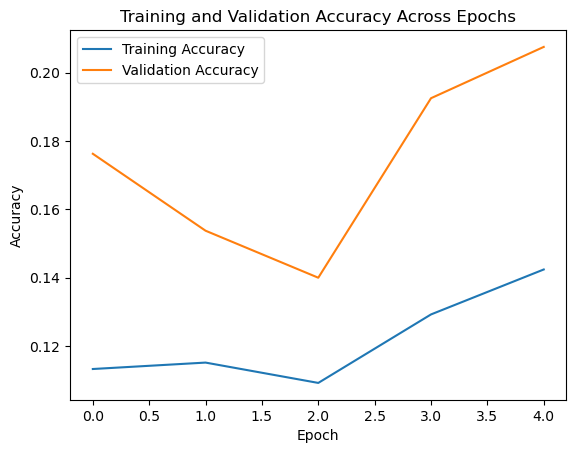

In [ ]:
# Evaluate and plot model performance
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Across Epochs')
plt.show()


## 5. Training and Results


In [3]:
import torch
import torchvision
from math import sqrt
from PIL import Image
import timm
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [8]:
import shutil
shutil.unpack_archive('/content/images_original.zip', '/content/new')

In [9]:
## create dataloader
audio_dataset = torchvision.datasets.ImageFolder('/content/new', transform=torchvision.transforms.Compose([
                                                                    torchvision.transforms.ToTensor(),
                                                                    torchvision.transforms.Resize([256, 256]),
                                                                    torchvision.transforms.CenterCrop([224, 224])
                                                                    ]))

# Split the dataset into three with the provided sizes
train_count = int(0.8 * len(audio_dataset))
valid_count = int(0.1 * len(audio_dataset))
test_count = len(audio_dataset) - train_count - valid_count

train_batch_size = 16
val_batch_size = 16
test_batch_size = 1

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    audio_dataset, (train_count, valid_count, test_count)
)

# Create dataloader objects
train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True
)
valid_dataset_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=val_batch_size, shuffle=True
)
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False
)
dataloaders = {
    "train": train_dataset_loader,
    "val": valid_dataset_loader,
    "test": test_dataset_loader,
}

In [10]:
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')
    
def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

In [18]:
n_epochs = 20
model_name = 'convnext_tiny'
save_path = '/content'
convnext_model = timm.create_model(model_name, num_classes = 10, pretrained=True)
valid_accu_l = []
valid_loss_l = []
# loss function
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-5

# Create the ADAM optimizer 
optimizer = torch.optim.Adam(convnext_model.parameters(), lr = learning_rate)

convnext_model = convnext_model.cuda()
train_loss_l = []

for i in tqdm(range(n_epochs)):

  # Train Step
  convnext_model.train()
  epoch_loss = []
  train_loss = 0

  for X, y in train_dataset_loader:
    X, y = X.cuda(), y.cuda()
    
    # Fill in the training loop
    # Clear the gradients
    optimizer.zero_grad()
    # Forward Pass
    target = convnext_model(X)
    # Find the Loss
    loss = loss_fn(target,y)
    # Calculate gradients 
    loss.backward()
    # Update Weights
    optimizer.step()
    # Calculate Loss
    train_loss += loss.item()
  epoch_loss.append(train_loss)
  train_loss_l.append(train_loss / len(train_dataset_loader)) # added to keep track of training loss


  # Eval Step
  convnext_model.eval()
  n_correct = 0
  n_loss = 0
  total_instance = 0
  with torch.no_grad(): ## disabled the gradient calculation
    for X, y in valid_dataset_loader:
      X = X.cuda() #, y.cuda()
      target = convnext_model(X)
      target = target.cpu()
      predicted = torch.argmax(target, dim=1).numpy()
      n_correct += (predicted == y.numpy()).sum().item()
      total_instance += len(X) 
      ## key: note that the length of dataloader is the number of batches but nt the lenght of the input X. 
      # Check if the model has predicted accurately
      pred_loss = loss_fn(target,y)
      n_loss += pred_loss
  
  valid_accu = n_correct / total_instance
  print(f'Validation accuracy: {(n_correct / total_instance):3f}')
  print(f'Validation loss: {(n_loss):3f}')
  valid_accu_l.append(valid_accu)
  valid_loss_l.append(n_loss)
  if valid_accu >= 0.85:
    valid_loss = n_loss
    save_checkpoint(f'{save_path}/{model_name}_epoch{i+1}_acc{valid_accu}.pt', convnext_model, valid_loss)

valid_accu_l_convnext = valid_accu_l

  5%|▌         | 1/20 [00:20<06:31, 20.59s/it]

Validation accuracy: 0.404040
Validation loss: 15.319665


 10%|█         | 2/20 [00:41<06:11, 20.64s/it]

Validation accuracy: 0.565657
Validation loss: 13.553371


 15%|█▌        | 3/20 [01:01<05:44, 20.29s/it]

Validation accuracy: 0.646465
Validation loss: 12.349744


 20%|██        | 4/20 [01:21<05:23, 20.21s/it]

Validation accuracy: 0.646465
Validation loss: 10.421837


 25%|██▌       | 5/20 [01:41<05:04, 20.33s/it]

Validation accuracy: 0.666667
Validation loss: 9.291197


 30%|███       | 6/20 [02:02<04:45, 20.36s/it]

Validation accuracy: 0.707071
Validation loss: 8.145972


 35%|███▌      | 7/20 [02:22<04:24, 20.33s/it]

Validation accuracy: 0.727273
Validation loss: 8.235733


 40%|████      | 8/20 [02:42<04:02, 20.20s/it]

Validation accuracy: 0.717172
Validation loss: 6.764020


 45%|████▌     | 9/20 [03:02<03:42, 20.19s/it]

Validation accuracy: 0.777778
Validation loss: 6.001648


 50%|█████     | 10/20 [03:25<03:30, 21.06s/it]

Validation accuracy: 0.818182
Validation loss: 6.630546


 55%|█████▌    | 11/20 [03:46<03:07, 20.89s/it]

Validation accuracy: 0.797980
Validation loss: 5.487541


 60%|██████    | 12/20 [04:07<02:49, 21.15s/it]

Validation accuracy: 0.818182
Validation loss: 5.159954


 65%|██████▌   | 13/20 [04:27<02:25, 20.85s/it]

Validation accuracy: 0.808081
Validation loss: 5.332094


 70%|███████   | 14/20 [04:47<02:03, 20.58s/it]

Validation accuracy: 0.838384
Validation loss: 4.365910


 75%|███████▌  | 15/20 [05:08<01:43, 20.66s/it]

Validation accuracy: 0.858586
Validation loss: 4.991410
Model saved to ==> /content/convnext_tiny_epoch15_acc0.8585858585858586.pt


 80%|████████  | 16/20 [05:28<01:22, 20.54s/it]

Validation accuracy: 0.828283
Validation loss: 4.197176


 85%|████████▌ | 17/20 [05:50<01:02, 20.88s/it]

Validation accuracy: 0.797980
Validation loss: 4.047945


 90%|█████████ | 18/20 [06:10<00:41, 20.67s/it]

Validation accuracy: 0.848485
Validation loss: 3.521331


 95%|█████████▌| 19/20 [06:31<00:20, 20.74s/it]

Validation accuracy: 0.838384
Validation loss: 4.064708


100%|██████████| 20/20 [06:52<00:00, 20.61s/it]

Validation accuracy: 0.868687
Validation loss: 3.356133
Model saved to ==> /content/convnext_tiny_epoch20_acc0.8686868686868687.pt


In [19]:
convnext_model.eval()
n_correct = 0
test_accu = []
with torch.no_grad(): ## disabled the gradient calculation
  for X, y in test_dataset_loader:
    X = X.cuda() #, y.cuda()
    target = convnext_model(X)
    target = target.cpu()
    predicted = torch.argmax(target, dim=1).numpy()
    n_correct += (predicted == y.numpy()).sum().item()
    # TODO: Check if the model has predicted accurately
test_accu.append(n_correct / len(test_dataset_loader)) 
print(f'Test accuracy: {(n_correct / len(test_dataset_loader)):3f}')

Test accuracy: 0.762376


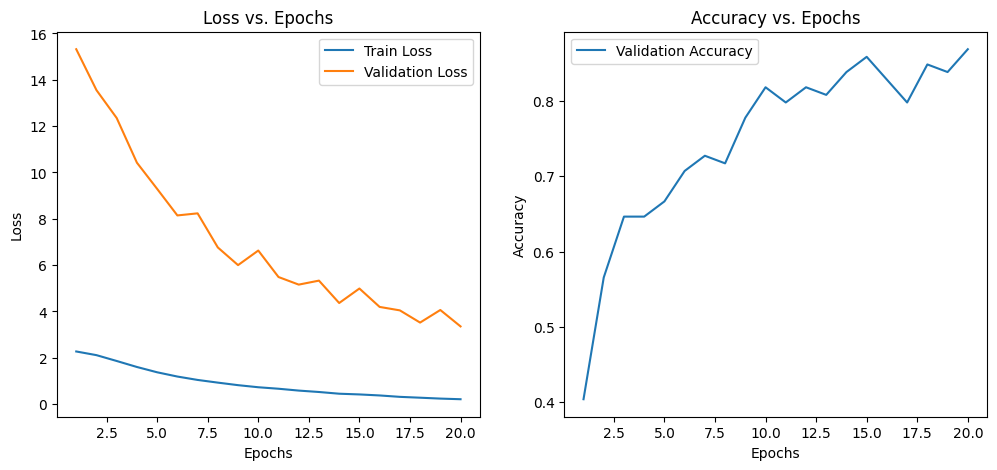

In [20]:
# Code to plot model performance

def plot_model_performance(epochs, train_losses, valid_losses, valid_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training and validation losses
    ax1.plot(np.arange(1, epochs + 1), train_losses, label='Train Loss')
    ax1.plot(np.arange(1, epochs + 1), valid_losses, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.legend()

    # Plot validation accuracy
    ax2.plot(np.arange(1, epochs + 1), valid_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.legend()

    plt.show()
    
plot_model_performance(n_epochs, train_loss_l, valid_loss_l, valid_accu_l)



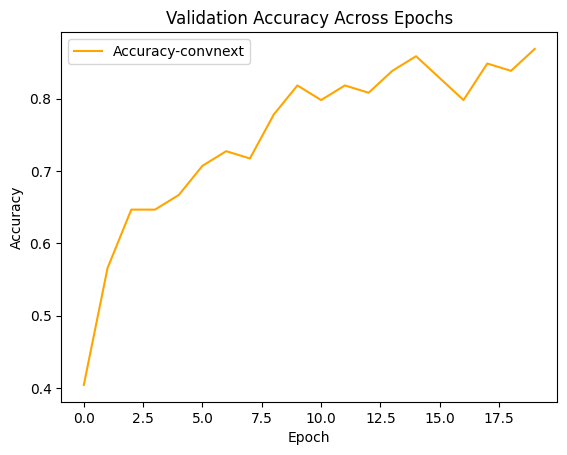

In [21]:
# Evaluate and plot model performance
plt.plot(valid_accu_l_convnext, label='Accuracy-convnext', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Across Epochs')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0b8c9dc-0347-45d3-9a41-0e3f670ba0cf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>